[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aalhossary/pyemgpipeline/blob/master/docs/notebooks/ex2_EMGMeasurementCollection.ipynb)

# Example 2 - Multiple EMG measurement definition and processing (using lower limb data)

This example shows the usage of class
[EMGMeasurementCollection](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#emgmeasurementcollection)
to process EMG data of multiple trials.

The data used in this example contains three files of subject #5 in ["EMG dataset in Lower Limb"](https://archive-beta.ics.uci.edu/ml/datasets/emg+dataset+in+lower+limb) from the UC Irvine Machine Learning Repository.
In particular, the data used here was collected from four lower limb muscles (rectus femoris, biceps femoris, vastus internus, and semitendinosus) in three trials, including sitting, standing, and gaiting.

## Package preparation

We install and import needed packages.

In [ ]:
!pip install pyemgpipeline -q

     |████████████████████████████████| 50 kB 3.9 MB/s 


In [ ]:
import os
import numpy as np
from matplotlib.figure import SubplotParams
import pyemgpipeline as pep

## Data preparation

First download the raw data from the UC Irvine Machine Learning Repository.

When finished, the compressed file "SEMG_DB1.rar" (~14MB) is saved in the "uci_lower_limb" subfolder.

In [ ]:
!rm -rf uci_lower_limb
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00278/SEMG_DB1.rar -P ./uci_lower_limb

Uncompress the downloaded file. This example will only use the files "5Nsen.txt", "5Npie.txt", and "5Nmar.txt" under folder "N_TXT".

In [ ]:
# !unrar x -inul uci_lower_limb/SEMG_DB1.rar uci_lower_limb  #This command extracts all files.
!unrar x -inul uci_lower_limb/SEMG_DB1.rar N_TXT/5Nsen.txt N_TXT/5Npie.txt N_TXT/5Nmar.txt uci_lower_limb  #This command extracts only the file needed in this example.

Signal data of each trial should be stored in a 2d ndarray with shape *(n_samples, n_channels)*, where each column represents data of one channel.
Data of multiple trials are organized in a *list*.

First we set up basic information of the data, including data path, channel names, sample rate, etc.

In [ ]:
data_folder = 'uci_lower_limb/N_TXT'
data_filenames = ['5Nsen.txt', '5Npie.txt', '5Nmar.txt']
trial_names = ['Sit', 'Stand', 'Gait']
channel_names = ['rectus femoris', 'biceps femoris', 'vastus internus', 'semitendinosus']
sample_rate = 1000

Signal data of multiple trials are stored in *all_data* of type *list*, where each element of the *list* is a 2d ndarray extracted from the raw data files of non-standard format.


In [ ]:
def load_uci_lower_limb_txt(_filepath):
    with open(_filepath) as fp:
        collect_values = np.array([])
        lines = fp.readlines()
        for line in lines[7:]:  # first few lines are data description
            items = [float(e) for e in line.split('\t')[:4] if e != '']  # last column is not EMG data
            if len(items) != 4:  # last few rows might not have EMG data
                continue
            collect_values = np.concatenate((collect_values, np.array(items)))
    _data = collect_values.reshape(-1, 4)
    return _data

all_data = []
for i in range(len(data_filenames)):
    filepath = os.path.join(data_folder, data_filenames[i])
    data = load_uci_lower_limb_txt(filepath)
    all_data.append(data)
    
all_data

[array([[ 0.0007, -0.0015, -0.0008,  0.003 ],
        [ 0.0075, -0.0015, -0.0023,  0.    ],
        [ 0.003 , -0.0015, -0.0008,  0.    ],
        ...,
        [-0.0015,  0.    , -0.0008,  0.003 ],
        [-0.0015,  0.    , -0.0008,  0.003 ],
        [-0.0015,  0.    , -0.0008,  0.003 ]]),
 array([[ 0.0045,  0.0022,  0.0007,  0.0037],
        [ 0.0142, -0.006 ,  0.0007,  0.    ],
        [ 0.0165, -0.006 ,  0.    ,  0.    ],
        ...,
        [ 0.0022,  0.0037, -0.0068,  0.0037],
        [ 0.0022,  0.0037, -0.0068,  0.0037],
        [ 0.0022,  0.0037, -0.0068,  0.0037]]),
 array([[ 0.0037, -0.0015, -0.0008, -0.0173],
        [ 0.0015, -0.0015, -0.0015, -0.006 ],
        [ 0.    , -0.0015,  0.    , -0.012 ],
        ...,
        [-0.003 , -0.0038, -0.0008,  0.0645],
        [-0.0053, -0.0015,  0.0015,  0.0622],
        [ 0.    , -0.0015, -0.0105, -0.0181]])]

In [ ]:
for k in range(len(all_data)):
    print(f'data shape of {k:6}: {all_data[k].shape}')

data shape of      0: (13480, 4)
data shape of      1: (15260, 4)
data shape of      2: (6563, 4)


We also set up the parameters for plotting with an instance of class
[EMGPlotParams](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.plots.html#emgplotparams).
Note that the whole setting configures the plotting of a single trial. Plotting of all trials use the same setting.

In [ ]:
emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=1,
    n_cols=4,
    fig_kwargs={
        'figsize': (16, 1.2),
        'subplotpars': SubplotParams(top=0.7, wspace=0.1, hspace=0),
    },
    line2d_kwargs={
        'color': 'b',
    }
)

## Data processing

We initialize an instance of class
[EMGMeasurementCollection](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#emgmeasurementcollection)
with signal data *all_data* and other information, which is responsible for furtuer processing and plotting.

In [ ]:
c = pep.wrappers.EMGMeasurementCollection(all_data, hz=sample_rate, trial_names=trial_names,
                                          channel_names=channel_names, emg_plot_params=emg_plot_params)

We also visualize the data before processing:

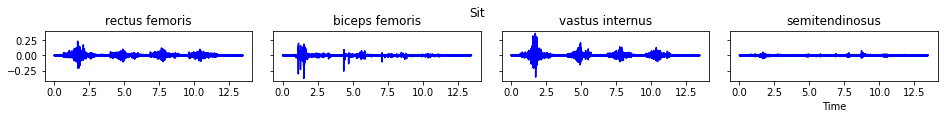

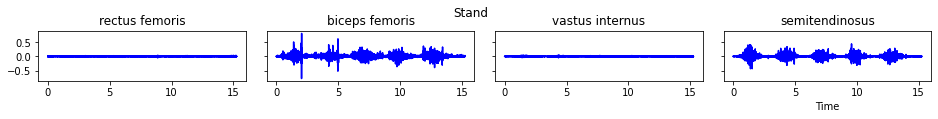

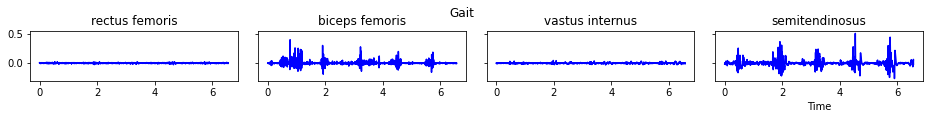

In [ ]:
c.plot()

Now we start to apply seven processing steps one by one and visualize the data after each step.

Step 1 is the DC offset removal.

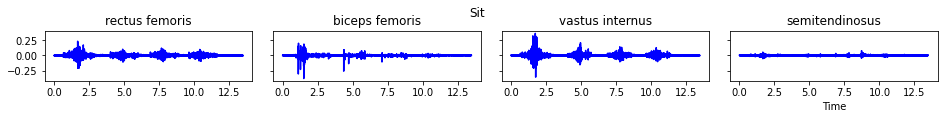

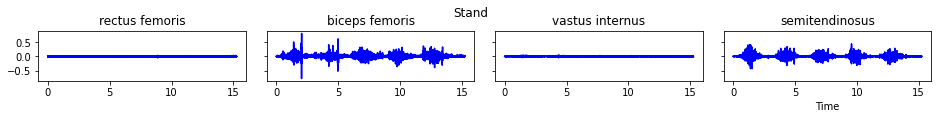

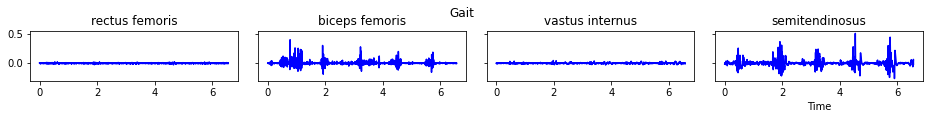

In [ ]:
c.apply_dc_offset_remover()
c.plot()

Step 2 is the bandpass filtering.

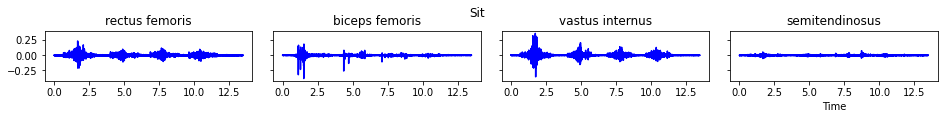

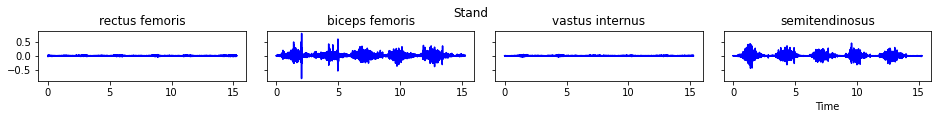

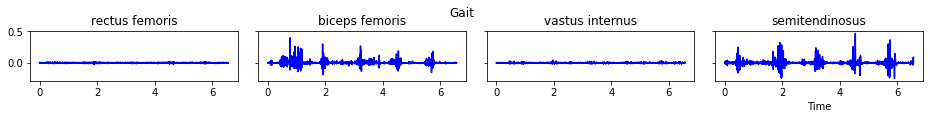

In [ ]:
c.apply_bandpass_filter(bf_order=4, bf_cutoff_fq_lo=10, bf_cutoff_fq_hi=450)
c.plot()

Step 3 is the full wave rectification.

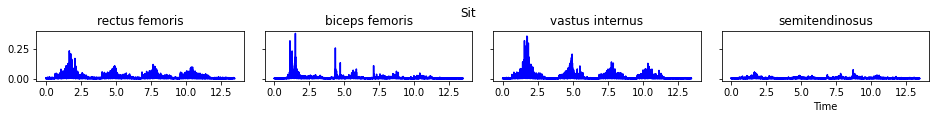

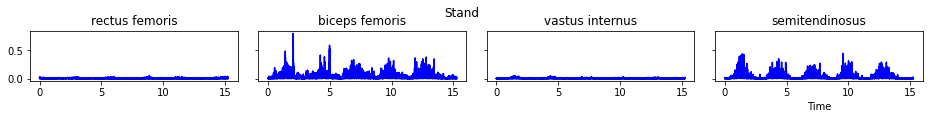

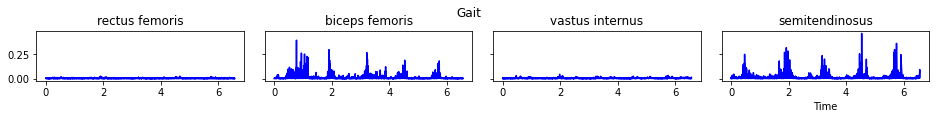

In [ ]:
c.apply_full_wave_rectifier()
c.plot()

Step 4 is the linear envelope.

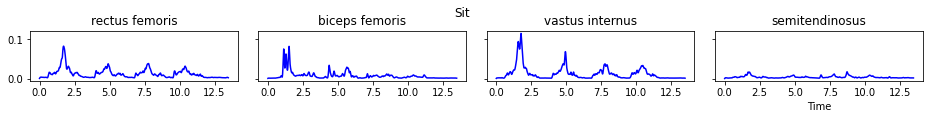

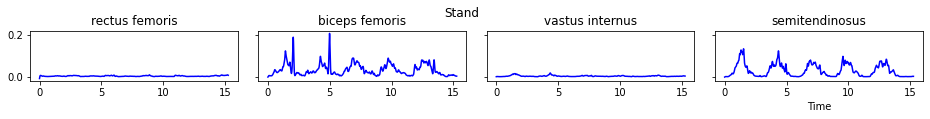

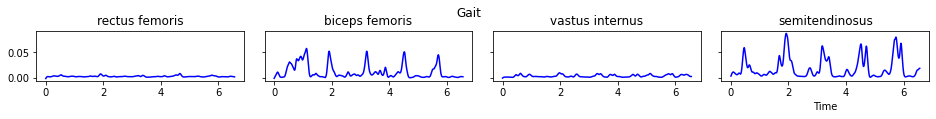

In [ ]:
c.apply_linear_envelope(le_order=4, le_cutoff_fq=6)
c.plot()

Step 5 is the end frame cutting.

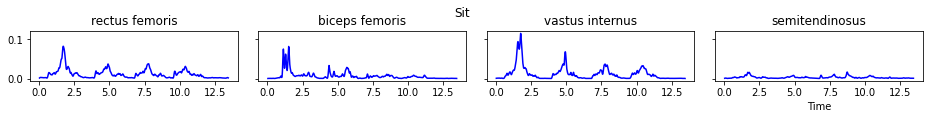

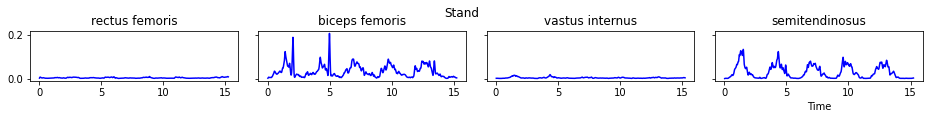

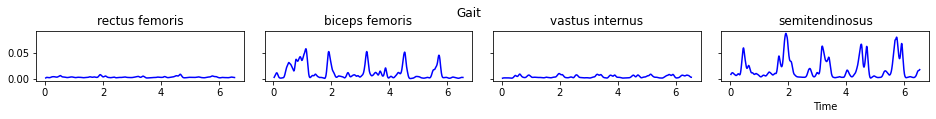

In [ ]:
c.apply_end_frame_cutter(n_end_frames=30)
c.plot()

Step 6 is the amplitude normalization. First we calculate *max_amplitude*, the maximum amplitude of each channel across trials, from the data.

In [ ]:
max_amplitude = c.find_max_amplitude_of_each_channel_across_trials()
print('max_amplitude:', max_amplitude)

max_amplitude: [0.08272218 0.20556472 0.11531935 0.13300577]


Then we use these values as the MVC (maximum voluntary contraction) for amplitude normalization.

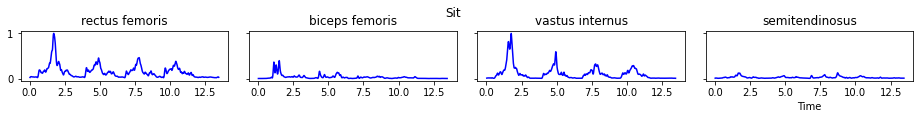

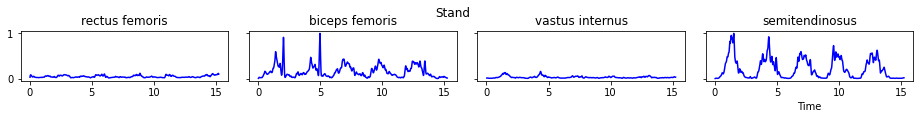

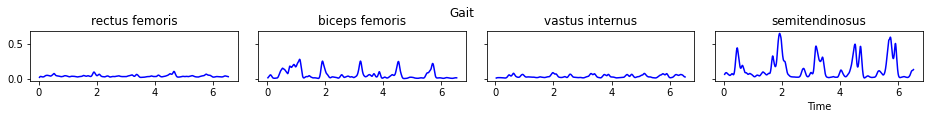

In [ ]:
c.apply_amplitude_normalizer(max_amplitude)
c.plot()

Step 7 is the segmentation.
For demonstration purpose, assume the segments of interest are in the time range (2.9, 12) for the sitting trial, in the time range (5.6, 14.5) for the standing trial, and in the whole range for the gaiting trial.

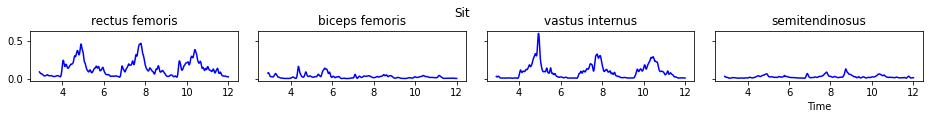

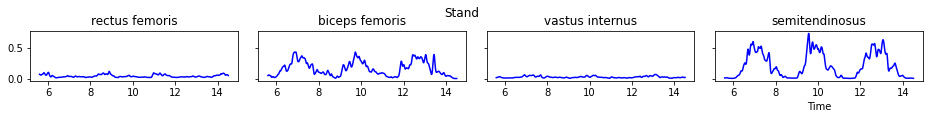

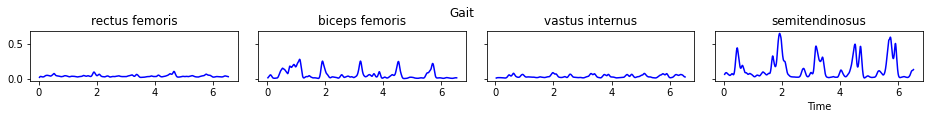

In [ ]:
all_beg_ts = [2.9, 5.6, 0]
all_end_ts = [12, 14.5, 999]
c.apply_segmenter(all_beg_ts, all_end_ts)
c.plot()

We have completed the processing steps.
The processed signal data can be accessed via *c.all_data* while the timestamp (initially derived from *sample_rate*) can be accessed via *c.all_timestamp* whenever needed.

In [ ]:
c.all_data

[array([[0.0920687 , 0.07740053, 0.03412713, 0.03382395],
        [0.09163069, 0.07772384, 0.03371283, 0.03392962],
        [0.09118   , 0.07803646, 0.03330972, 0.03402932],
        ...,
        [0.02820274, 0.00735341, 0.01221804, 0.01764664],
        [0.02831608, 0.0073656 , 0.01220219, 0.01761076],
        [0.02843199, 0.00737811, 0.01218871, 0.01757233]]),
 array([[0.07723283, 0.05704184, 0.02298162, 0.01810079],
        [0.07700917, 0.05733228, 0.02309847, 0.0180855 ],
        [0.07679376, 0.05763172, 0.02321987, 0.01807356],
        ...,
        [0.05755993, 0.00988673, 0.02684806, 0.01269028],
        [0.05715868, 0.00993258, 0.0269777 , 0.01266372],
        [0.05676127, 0.00998159, 0.0271074 , 0.01263688]]),
 array([[0.01953295, 0.01334102, 0.00961191, 0.06336577],
        [0.02025041, 0.01389486, 0.00986346, 0.06437713],
        [0.02094466, 0.01444859, 0.01010689, 0.06536599],
        ...,
        [0.02983576, 0.01265461, 0.02532435, 0.13096556],
        [0.02970596, 0.012626

In [ ]:
c.all_timestamp

[array([ 2.9  ,  2.901,  2.902, ..., 11.998, 11.999, 12.   ]),
 array([ 5.6  ,  5.601,  5.602, ..., 14.498, 14.499, 14.5  ]),
 array([0.03 , 0.031, 0.032, ..., 6.53 , 6.531, 6.532])]

The processed data can also be exported to csv files. Note that besides signal data, timestamp is also included in the first column of each csv file.

In [ ]:
all_csv_path = ['ex2_sit.csv', 'ex2_stand.csv', 'ex2_gait.csv']
c.export_csv(all_csv_path)

Besides, the indexing operator *[]* can be used to extract the information of a single trial.

In [ ]:
isinstance(c[0], pep.wrappers.EMGMeasurement)

True

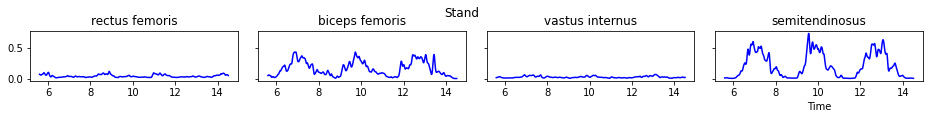

In [ ]:
c[1].plot()